In [21]:
import numpy as np
import pandas as pd
from pyod.utils.data import generate_data
from pyod.models.hbos import HBOS
import matplotlib.pyplot as plt
from pyod.models.combination import aom, moa, average, maximization # instalar la librería conda install combo
from pyod.utils.utility import standardizer
from pyod.models.hbos import HBOS
from sklearn.model_selection import train_test_split

In [2]:
# Importando los datos
emicron = pd.read_excel('emicron_21_final_ambulantes.xlsx')

In [7]:
#emicron['p3053'].head()
emicron.shape
#emicron['id'].head()
#len(emicron)

(2702, 157)

In [4]:
# Identificando las columnas que tienen 0 o nulos en todas sus filas
#emicron['p3092'].head().unique()
columnas_con_nan = emicron.columns[emicron.isna().sum() == len(emicron)]

In [5]:
# Identificando las filas con valores nulos
print(columnas_con_nan)

Index(['p3095', 'p3096', 'p3097', 'p3055', 'p3056_d', 'p3057_d', 'p3092',
       'p3093', 'p4017', 'p4018', 'p4031', 'p4032'],
      dtype='object')


In [6]:
# Se establece como índice del dataframe al identificador. Esto para identificar el código de los anómalos al final del proceso.
emicron.set_index('id', inplace = True)

In [9]:
# Eliminando las columnas que no se tienen en cuenta en el modelo (valores nulos e identificadores)
emicron.drop(['mes_ref', 'directorio', 'secuencia_p', 'secuencia_encuesta', 'p3095', 'p3096', 'p3055', 'p3097', 'p3056_d', 'p3057_d', 'p3092', 'p3093', 'p4017', 'p4018', 'p4031', 'p4032'], axis = 1, inplace = True)

In [10]:
emicron.dtypes

cod_depto                     int64
area                        float64
clase_te                      int64
p35                           int64
p241                          int64
                             ...   
ventas_mes_anterior           int64
ventas_mes_anio_anterior    float64
ventas_anio_anterior        float64
valor_agregado                int64
ingreso_mixto                 int64
Length: 141, dtype: object

In [16]:
# Borrando las posibles filas que tengan valores vacíos en toda las variables
emicron.dropna(how = 'all', axis = 0)

,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p4028,p4029,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto
id,,,,,,,,,,,,,,,,,,,,,
529996411,73,73.0,1,2,35,1,0.00000,0.000000,1.000000,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,180000,400000,1.369027e+06,8.000000e+05,116000,116000
530006311,63,63.0,1,1,61,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,300000,870000,8.700000e+05,7.830000e+06,300000,300000
530011312,76,76.0,1,2,49,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,700000,650000,8.000000e+05,6.000000e+06,300000,300000
530019511,50,50.0,1,2,38,1,0.00000,0.000000,2.000000,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,300000,700000,7.500000e+05,7.800000e+06,274000,274000
530044811,5,5.0,1,2,47,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,50000,700000,1.369027e+06,5.498833e+06,450000,450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603359111,50,50.0,1,2,51,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,750000,1500000,1.369027e+06,1.526867e+07,750000,750000
603365811,50,50.0,1,1,25,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,500000,800000,1.369027e+06,1.526867e+07,490000,490000
603390811,50,50.0,1,2,48,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,300000,700000,6.000000e+05,5.000000e+06,320000,320000


In [12]:
# Reemplazando los valores nan por el promedio
emicron = emicron.fillna(emicron.mean())

In [17]:
# Verificando que no existan valores nulos en el dataset
print(f"¿Existen valores nulos?: {emicron.isnull().values.any()}. ¿Cunántos valores nulos hay?: {emicron.isnull().sum().sum()}")

¿Existen valores nulos?: False. ¿Cunántos valores nulos hay?: 0


In [22]:
# Dividiendo el dataset en datos de entrenamiento y datos de validación

X_train, X_test = train_test_split(emicron, test_size = 0.3, random_state = 0)

In [23]:
X_train.head()

,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p4028,p4029,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto
id,,,,,,,,,,,,,,,,,,,,,
554192513,76,76.000000,1,2,66,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000,0.000000,5.215741e+06,100000,600000,0.0,3000000.0,140000,140000
557936913,47,36.133191,2,2,39,2,0.43254,0.279762,0.605159,2,...,59464.285714,558487.637363,9637.362637,5.215741e+06,900000,2700000,2500000.0,18500000.0,900000,900000
536955111,52,52.000000,1,1,33,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000,0.000000,5.215741e+06,500000,600000,400000.0,5000000.0,400000,400000
552299513,66,66.000000,1,2,55,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000,0.000000,5.215741e+06,600000,1600000,1600000.0,8300000.0,630000,630000
555056711,63,63.000000,1,2,58,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000,0.000000,5.215741e+06,900000,5200000,5000000.0,45000000.0,960000,960000


In [24]:
print(f"El tamaño de los datos de entrenamiento es: {X_train.shape} y de validación: {X_test.shape}")

El tamaño de los datos de entrenamiento es: (1891, 141) y de validación: (811, 141)


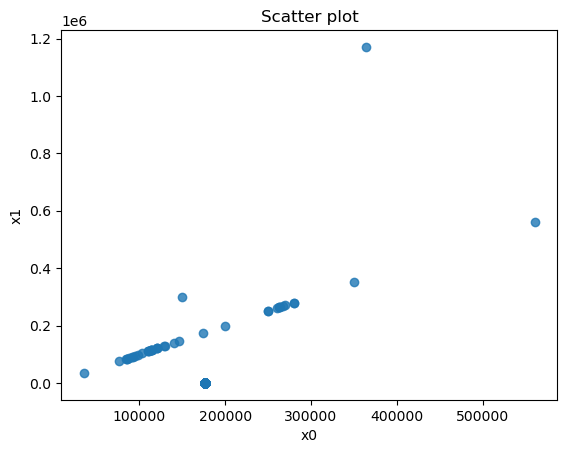

In [25]:
# Graficando las variables 0 y 1 en un scatter plot e identificando atípicos. Amarillo atípicos, morados, datos normales
plt.scatter(X_train['p3089'], X_train['prestaciones'], alpha = 0.8) # c es la lista de colores de acuerdo con los valores únicos de esta variable, la cual en la líne anterior es 1,0
plt.title("Scatter plot")
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [26]:
n_bins = 50
hbos = HBOS(n_bins = n_bins, contamination = 0.05)
hbos.fit(X_train)

HBOS(alpha=0.1, contamination=0.05, n_bins=50, tol=0.5)

In [28]:
print("El umbral para los datos de ratio contaminados: ", hbos.threshold_)

El umbral para los datos de ratio contaminados:  107.53627478551165


In [29]:
# Creando las puntuaciones para los datos de entrenamiento y prediciendo cuando una instancia es atípica o no
# la función predict compara la puntuación de los datos atípicoscon el umbral. Si la puntuación de un atípico es mayor al umbral, la función asigna 1, o en caso contrario , 0
# Datos de entrenamiento

Y_train_scores = hbos.decision_function(X_train)
Y_train_pred = hbos.predict(X_train)

# Datos de testeo o validación
Y_test_scores = hbos.decision_function(X_test)
Y_test_pred = hbos.predict(X_test)

In [30]:
Y_train_pred
#contanto el número de valores predichos
def count_stat(vector):
    unique, counts = np.unique(vector,
                               return_counts = True)
    return dict(zip(unique, counts))

print("Los datos de entrenamiento: ", count_stat(Y_train_pred))
print("Los datos de validación o test: ", count_stat(Y_test_pred))

Los datos de entrenamiento:  {0: 1796, 1: 95}
Los datos de validación o test:  {0: 774, 1: 37}


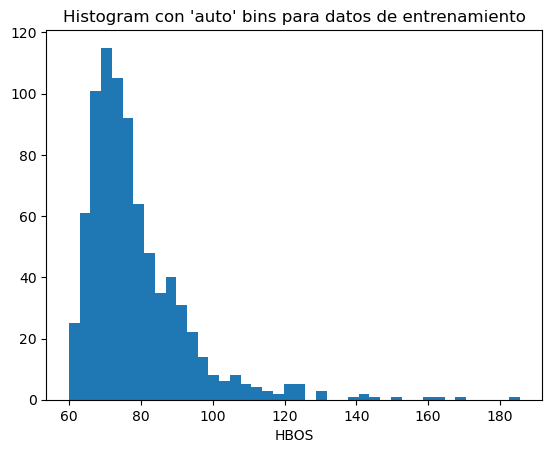

In [31]:
plt.hist(Y_test_scores, bins = 'auto')
plt.title("Histogram con 'auto' bins para datos de entrenamiento")
plt.xlabel('HBOS')
plt.show()

In [32]:
threshold = hbos.threshold_

In [33]:
def descriptive_stat_threshold(df, pred_score, threshold, opcion = 1):
    # Observemos cuántos 0 o 1 hay
    if opcion == 1:    
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        # Ahora mostraremos las estadísticas resumen
        cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns = {'Anomaly_Score': 'Count'})
        # Conto del conteo
        cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
        # Promedio
        stat = df.groupby('Group').mean().round(2).reset_index()
        # Poniendo el conteo y el promedio juntos
        stat = cnt.merge(stat, left_on = 'Group', right_on = 'Group')
        return(stat)
    else:
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        return(df)

In [34]:
# Obteniendo la tabla resumen de outliers en la data de entrenamiento
descriptive_stat_threshold(X_train, Y_train_scores, threshold)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,Group,Count,Count %,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,...,p4029,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto,Anomaly_Score
0,Normal,1796,94.976203,36.39,35.63,1.03,1.50,47.51,1.82,0.42,...,631815.69,11933.96,5218308.07,537967.35,1799270.59,1325875.58,14764984.89,598887.56,562882.81,76.77
1,Outlier,95,5.023797,41.99,40.99,1.04,1.44,48.64,1.53,0.68,...,511299.54,12884.67,5192417.15,801625.33,4596112.19,3429936.95,39449147.58,1253838.49,940702.75,123.75


In [35]:
# Obteniendo la data en la data de clasificación en con los datos de entrenamiento
descriptive_stat_threshold(X_train, Y_train_scores, threshold, 2)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto,Anomaly_Score,Group
id,,,,,,,,,,,,,,,,,,,,,
554192513,76,76.000000,1,2,66,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,100000,600000,0.000000e+00,3.000000e+06,140000,140000,63.167654,Normal
557936913,47,36.133191,2,2,39,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,900000,2700000,2.500000e+06,1.850000e+07,900000,900000,72.124016,Normal
536955111,52,52.000000,1,1,33,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,500000,600000,4.000000e+05,5.000000e+06,400000,400000,77.053967,Normal
552299513,66,66.000000,1,2,55,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,600000,1600000,1.600000e+06,8.300000e+06,630000,630000,72.228609,Normal
555056711,63,63.000000,1,2,58,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,900000,5200000,5.000000e+06,4.500000e+07,960000,960000,94.199018,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551148611,54,54.000000,1,2,32,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,190000,700000,0.000000e+00,0.000000e+00,170000,170000,65.801212,Normal
540582913,23,23.000000,1,2,36,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,40000,120000,1.369027e+06,1.526867e+07,40000,40000,63.363330,Normal
541534412,20,36.133191,1,1,47,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,400000,1200000,1.369027e+06,1.526867e+07,400000,400000,71.764596,Normal


In [36]:
# Obteniendo la tabla resumen de outliers en la data de validación
descriptive_stat_threshold(X_test, Y_test_scores, threshold)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,Group,Count,Count %,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,...,p4029,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto,Anomaly_Score
0,Normal,774,95.437731,37.28,36.42,1.02,1.52,47.28,1.84,0.40,...,410723.95,4196.11,5212646.19,531106.32,1611417.34,1182703.93,12862720.91,601720.50,584360.10,76.27
1,Outlier,37,4.562269,43.81,42.09,1.00,1.38,44.84,1.43,0.89,...,211319.65,3646.57,5215740.74,935947.46,3403951.11,2069798.31,27962433.04,1556246.68,974480.46,126.98


In [37]:
# Obteniendo la data en la data de clasificación en con los datos de entrenamiento
descriptive_stat_threshold(X_test, Y_test_scores, threshold, 2)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto,Anomaly_Score,Group
id,,,,,,,,,,,,,,,,,,,,,
531334611,54,54.0,1,1,67,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,300000,600000,1.369027e+06,3.000000e+06,270000,270000,82.414586,Normal
555511311,18,18.0,1,1,76,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,350000,400000,5.000000e+05,6.000000e+06,255000,255000,103.585011,Normal
542214811,73,73.0,1,2,60,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,250000,600000,0.000000e+00,4.000000e+06,552500,552500,97.068251,Normal
551061212,19,19.0,1,1,61,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,389412,870000,8.166660e+05,4.225000e+06,389412,389412,72.459569,Normal
546571811,8,8.0,1,2,39,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,600000,2160000,1.369027e+06,1.526867e+07,681000,681000,64.394101,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553237511,8,8.0,1,1,59,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,400000,550000,3.000000e+05,4.650000e+06,406000,406000,71.877671,Normal
554000712,23,23.0,1,1,59,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,100000,200000,3.000000e+05,2.500000e+06,100000,100000,85.313294,Normal
601662015,76,76.0,1,2,58,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,80000,1600000,9.600000e+05,2.000000e+06,1015000,1015000,119.235518,Outlier


In [39]:
# Corroborando este dato outlier, con id = 601662015, en la base original:
emicron.loc[601662015,:]

cod_depto                        76.0
area                             76.0
clase_te                          1.0
p35                               2.0
p241                             58.0
                              ...    
ventas_mes_anterior         1600000.0
ventas_mes_anio_anterior     960000.0
ventas_anio_anterior        2000000.0
valor_agregado              1015000.0
ingreso_mixto               1015000.0
Name: 601662015, Length: 141, dtype: float64

In [40]:
# Estandarizando los datos

X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Generando diez modelos HBOS por rangos de 5, 10, 15, 20, 25, 30, 50, 60, 70 y 100 bins
# testando el rango de agrupaciones (binning)
k_list = [5,10,15,20,25,30,50,60,75,100]
n_clf = len(k_list)
# Se crea un dataframe vacío para los datos de entrenamiento y de test para almacenar las predicciones. Habrá diez modelos por lo que el data frame tendrá 10 columnas
#Almacenar los resultados
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modelando

for i in range(n_clf):
    k = k_list[i]
    hbos = HBOS(n_bins = n_bins)
    hbos.fit(X_train_norm)
    # Almacenando los resultados en cada columna
    train_scores[:, i] = hbos.decision_function(X_train_norm)
    test_scores[:, i] = hbos.decision_function(X_test_norm)

# Normzalizando los puntajes de decision después de combinarlos
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)
    


In [41]:
train_scores_norm

array([[-0.79275645, -0.79275645, -0.79275645, ..., -0.79275645,
        -0.79275645, -0.79275645],
       [-0.5556407 , -0.5556407 , -0.5556407 , ..., -0.5556407 ,
        -0.5556407 , -0.5556407 ],
       [-0.16165336, -0.16165336, -0.16165336, ..., -0.16165336,
        -0.16165336, -0.16165336],
       ...,
       [-0.98177141, -0.98177141, -0.98177141, ..., -0.98177141,
        -0.98177141, -0.98177141],
       [ 0.63083245,  0.63083245,  0.63083245, ...,  0.63083245,
         0.63083245,  0.63083245],
       [ 0.56717608,  0.56717608,  0.56717608, ...,  0.56717608,
         0.56717608,  0.56717608]])

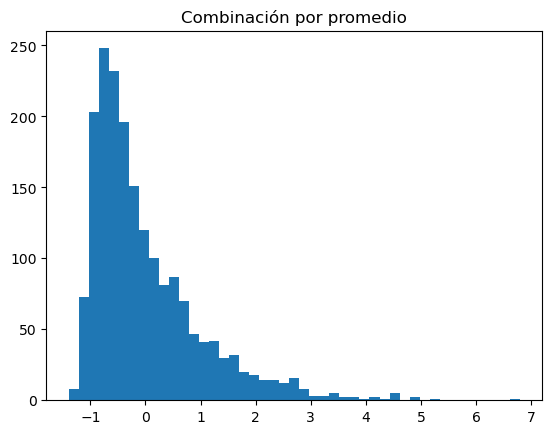

In [42]:
# El promedio de las predicciones de los 10 puntajes están en y_by_average abajo. Se crea esto en un histograma
# El resultado "y_by_average" es una columna:
Y_train_by_average = average(train_scores_norm)
Y_test_by_average = average(test_scores_norm)
plt.hist(Y_train_by_average, bins = 'auto')
plt.title("Combinación por promedio")
plt.show()

In [43]:
descriptive_stat_threshold(X_train, Y_train_by_average, 4)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,Group,Count,Count %,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,...,p4029,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto,Anomaly_Score
0,Normal,1878,99.312533,36.68,35.92,1.03,1.50,47.56,1.81,0.43,...,587239.10,12028.74,5218195.97,543846.52,1849909.82,1343219.67,1.502805e+07,613617.52,572768.91,-0.03
1,Outlier,13,0.687467,35.46,32.02,1.08,1.23,48.38,1.08,1.80,...,6190724.11,5189.35,5045299.15,1615384.62,14922307.69,14196153.85,1.571467e+08,3257154.77,1895713.54,4.69


In [44]:
descriptive_stat_threshold(X_train, Y_train_by_average, 4, 2)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto,Anomaly_Score,Group
id,,,,,,,,,,,,,,,,,,,,,
554192513,76,76.000000,1,2,66,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,100000,600000,0.000000e+00,3.000000e+06,140000,140000,-0.792756,Normal
557936913,47,36.133191,2,2,39,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,900000,2700000,2.500000e+06,1.850000e+07,900000,900000,-0.555641,Normal
536955111,52,52.000000,1,1,33,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,500000,600000,4.000000e+05,5.000000e+06,400000,400000,-0.161653,Normal
552299513,66,66.000000,1,2,55,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,600000,1600000,1.600000e+06,8.300000e+06,630000,630000,-0.421105,Normal
555056711,63,63.000000,1,2,58,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,900000,5200000,5.000000e+06,4.500000e+07,960000,960000,2.065064,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551148611,54,54.000000,1,2,32,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,190000,700000,0.000000e+00,0.000000e+00,170000,170000,-0.973554,Normal
540582913,23,23.000000,1,2,36,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,40000,120000,1.369027e+06,1.526867e+07,40000,40000,-1.131752,Normal
541534412,20,36.133191,1,1,47,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,400000,1200000,1.369027e+06,1.526867e+07,400000,400000,-0.981771,Normal


In [45]:
tabla_anomalos_emicron = descriptive_stat_threshold(X_train, Y_train_by_average, 4, 2)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


In [52]:
atipicos = tabla_anomalos_emicron[tabla_anomalos_emicron['Group'] == 'Outlier']
atipicos.head()

,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto,Anomaly_Score,Group
id,,,,,,,,,,,,,,,,,,,,,
538096711,54,54.000000,1,1,36,1,1.00000,0.000000,1.000000,1,...,9637.362637,3.000000e+06,1100000,2700000,1000000.0,3000000.0,1552000,1152000,4.084699,Outlier
553311411,18,18.000000,1,2,40,1,3.00000,1.000000,1.000000,1,...,0.000000,5.215741e+06,1350000,10800000,4680000.0,51860000.0,3904211,859271,5.164064,Outlier
536426411,76,36.133191,1,1,35,1,1.00000,1.000000,0.000000,1,...,0.000000,5.215741e+06,1500000,3600000,3000000.0,33000000.0,2187917,1687917,4.307603,Outlier
552741011,47,47.000000,1,1,43,1,2.00000,0.000000,1.000000,1,...,0.000000,5.215741e+06,2250000,7280000,5850000.0,76570000.0,3426000,2516000,4.053300,Outlier
535771211,8,8.000000,1,1,38,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,2300000,26800000,44000000.0,367500000.0,2360000,2220000,4.437755,Outlier


In [53]:
atipicos.to_excel('HBOS_tabla_anomalos_emicron.xlsx', index = True)